# Scalable workflow for big datasets

In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
data_name = 'Pancreas_with_cc'

Global seed set to 0


You need to change this to suitable directories on your system:

In [2]:
# Data name, where to download data and where to save results
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/Pancreas_with_cc/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/'

In [3]:
# # Downloading data into specified directory:
# os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

Load the data and extract most variable genes (and optionally remove some clusters). We expect the adata object to contain spliced and unspliced raw UMI counts in adata.layers['spliced'] and adata.layers['unspliced']. Spliced and unspliced counts can be for example be quantified with the [velocyto method](http://velocyto.org/). [Starsolo](https://github.com/alexdobin/STAR/blob/master/docs/STARsolo.md#velocyto-splicedunsplicedambiguous-quantification) also has the option to run velocyto as part of the general mapping, demultiplexing and count quantification pipeline. For more information on spliced and unspliced count quantification  [this publication](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008585) gives a good overview. 

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)


Keeping at most 100000 cells per cluster
Filtered out 20801 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


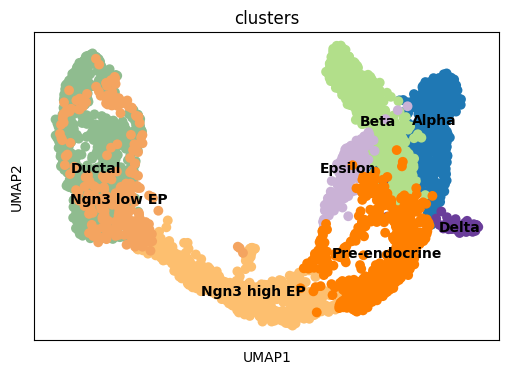

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

We initialize the model, which includes automatically setting a maximal number of modules, based on the number of Louvain clusters (times 1.15) in the data.

In [6]:
c2f.Cell2fate_DynamicalModel_PriorKnowledge.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
n_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...


2023-12-11 15:50:01.486336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 15:50:01.486727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 15:50:01.599032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 15:50:07.239712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of Leiden Clusters: 13
Maximal Number of Modules: 14


Use this guide for quantile export

In [8]:
from cell2fate._pyro_mixin import MyAutoHierarchicalNormalMessenger
mod = c2f.Cell2fate_DynamicalModel_PriorKnowledge(adata,
                                                  n_modules = n_modules,
                                                  guide_class=MyAutoHierarchicalNormalMessenger,
                                                  cluster_column = 'clusters',
                                                  initial_clusters = ['Ductal'],
                                                  Tmax_prior={"mean": 500., "sd": 150.})

Training the model:

In [9]:
from cell2fate._pyro_mixin import PyroTrainingPlan_ClippedAdamDecayingRate
mod.train(batch_size = 500, max_epochs = 4000, **{'training_plan' : PyroTrainingPlan_ClippedAdamDecayingRate},
         early_stopping = True, early_stopping_min_delta = 10**(-4),
         early_stopping_monitor = 'elbo_train', early_stopping_patience = 10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 125/4000:   3%|███▏                                                                                                  | 125/4000 [04:16<2:12:46,  2.06s/it, v_num=1, elbo_train=1.15e+7]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 11471229.000. Signaling Trainer to stop.


Exporting relevant model parameters to the anndata object:

In [10]:
adata=mod.export_posterior_quantiles(adata,batch_size=200)

Computing posterior quantile 0.75, data batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.24it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

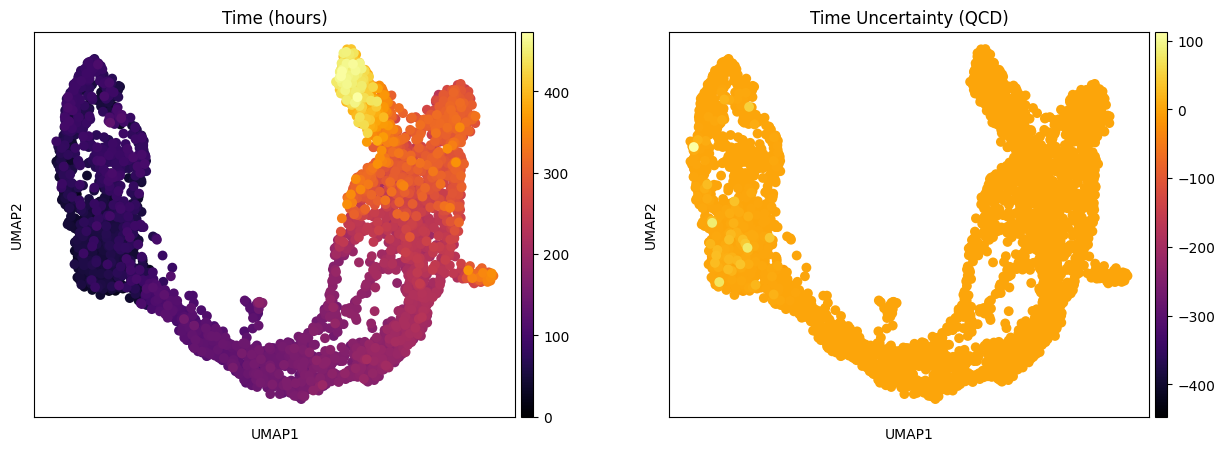

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (QCD)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time_nModules' + str(n_modules) + '.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

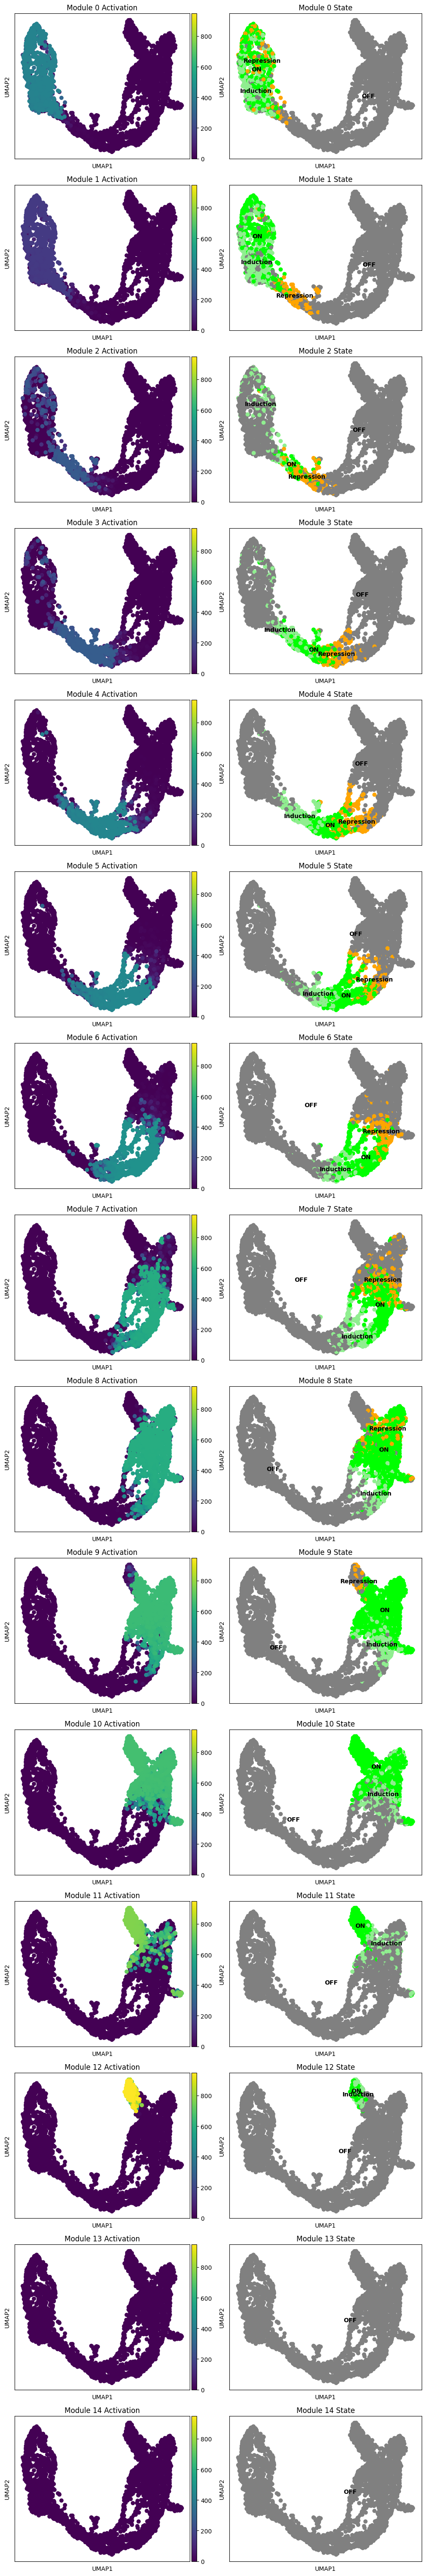

In [12]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

This is an alternative way to visualize module activation over time:

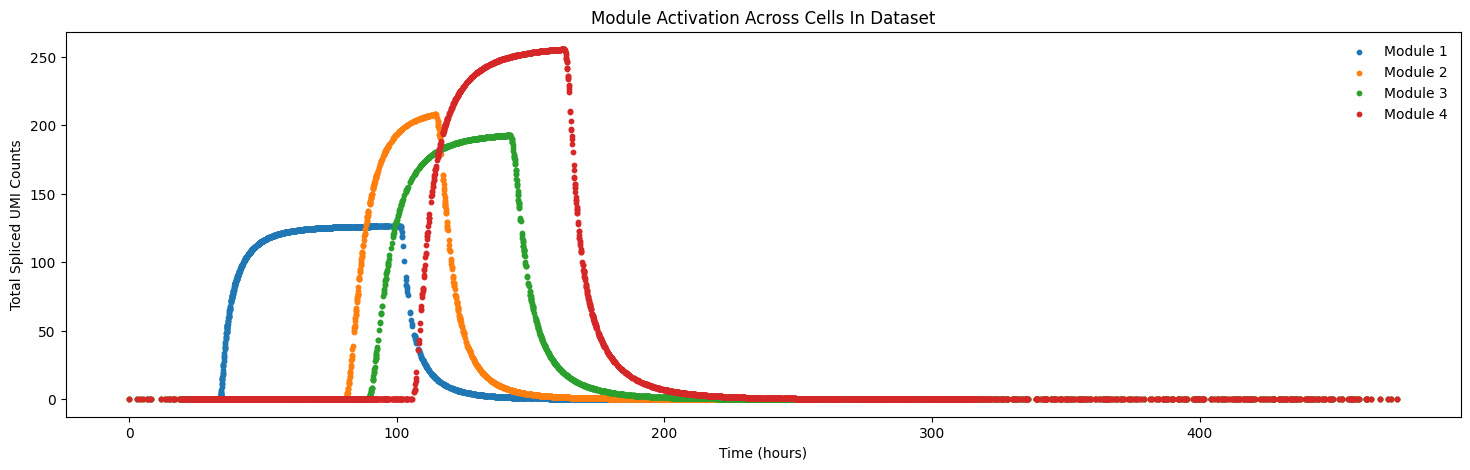

In [13]:
mod.compare_module_activation(adata, chosen_modules = [1,2,3,4],
                         save = results_path + data_name + 'module_activation_comparison.pdf')

For large datasets (> 10000 cells) we recommend the scalable scVelo workflow for computing and plotting the velocity graph, which is used in this method:

Computing total RNAvelocity ...


  0%|          | 0/3696 [00:00<?, ?cells/s]

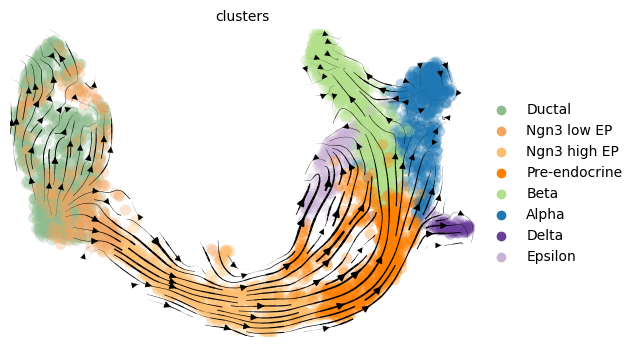

In [14]:
mod.compute_and_plot_total_velocity_scvelo(adata, save = results_path + data_name + 'total_velocity_plots.png', delete = False)

For a visualization that is more similar to the scvelo plots:

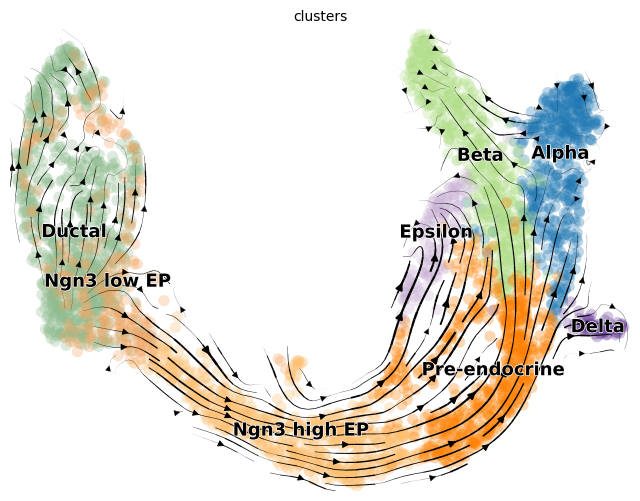

In [16]:
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(results_path + data_name + 'total_velocity_plots.png')

After computing velocities, relative module activations for trajectories can be plotted.

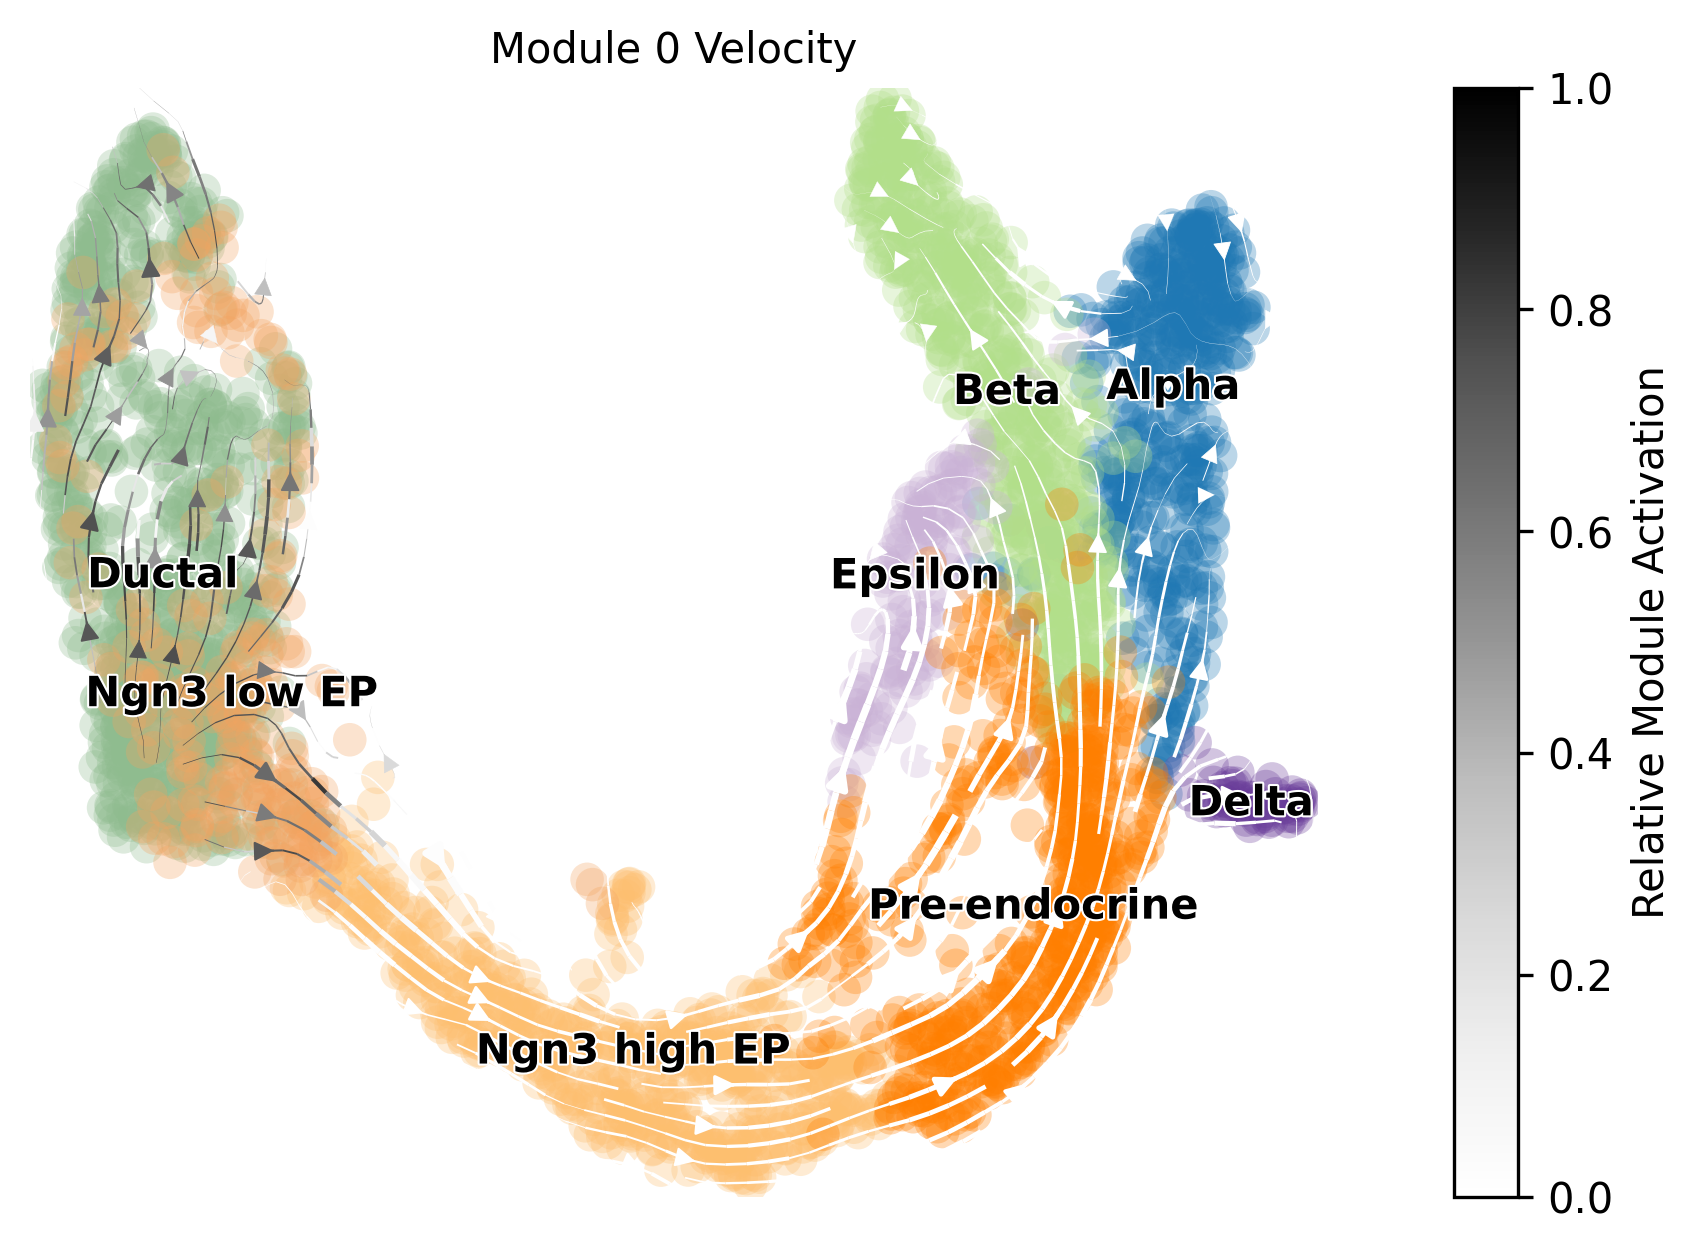

In [17]:
chosen_module = 0
mod.visualize_module_trajectories(adata, chosen_module)

Keyword arguments for plotting can also be defined to further adjust velocity graphs, such as the location of the legend (cluster names) and the cmap.

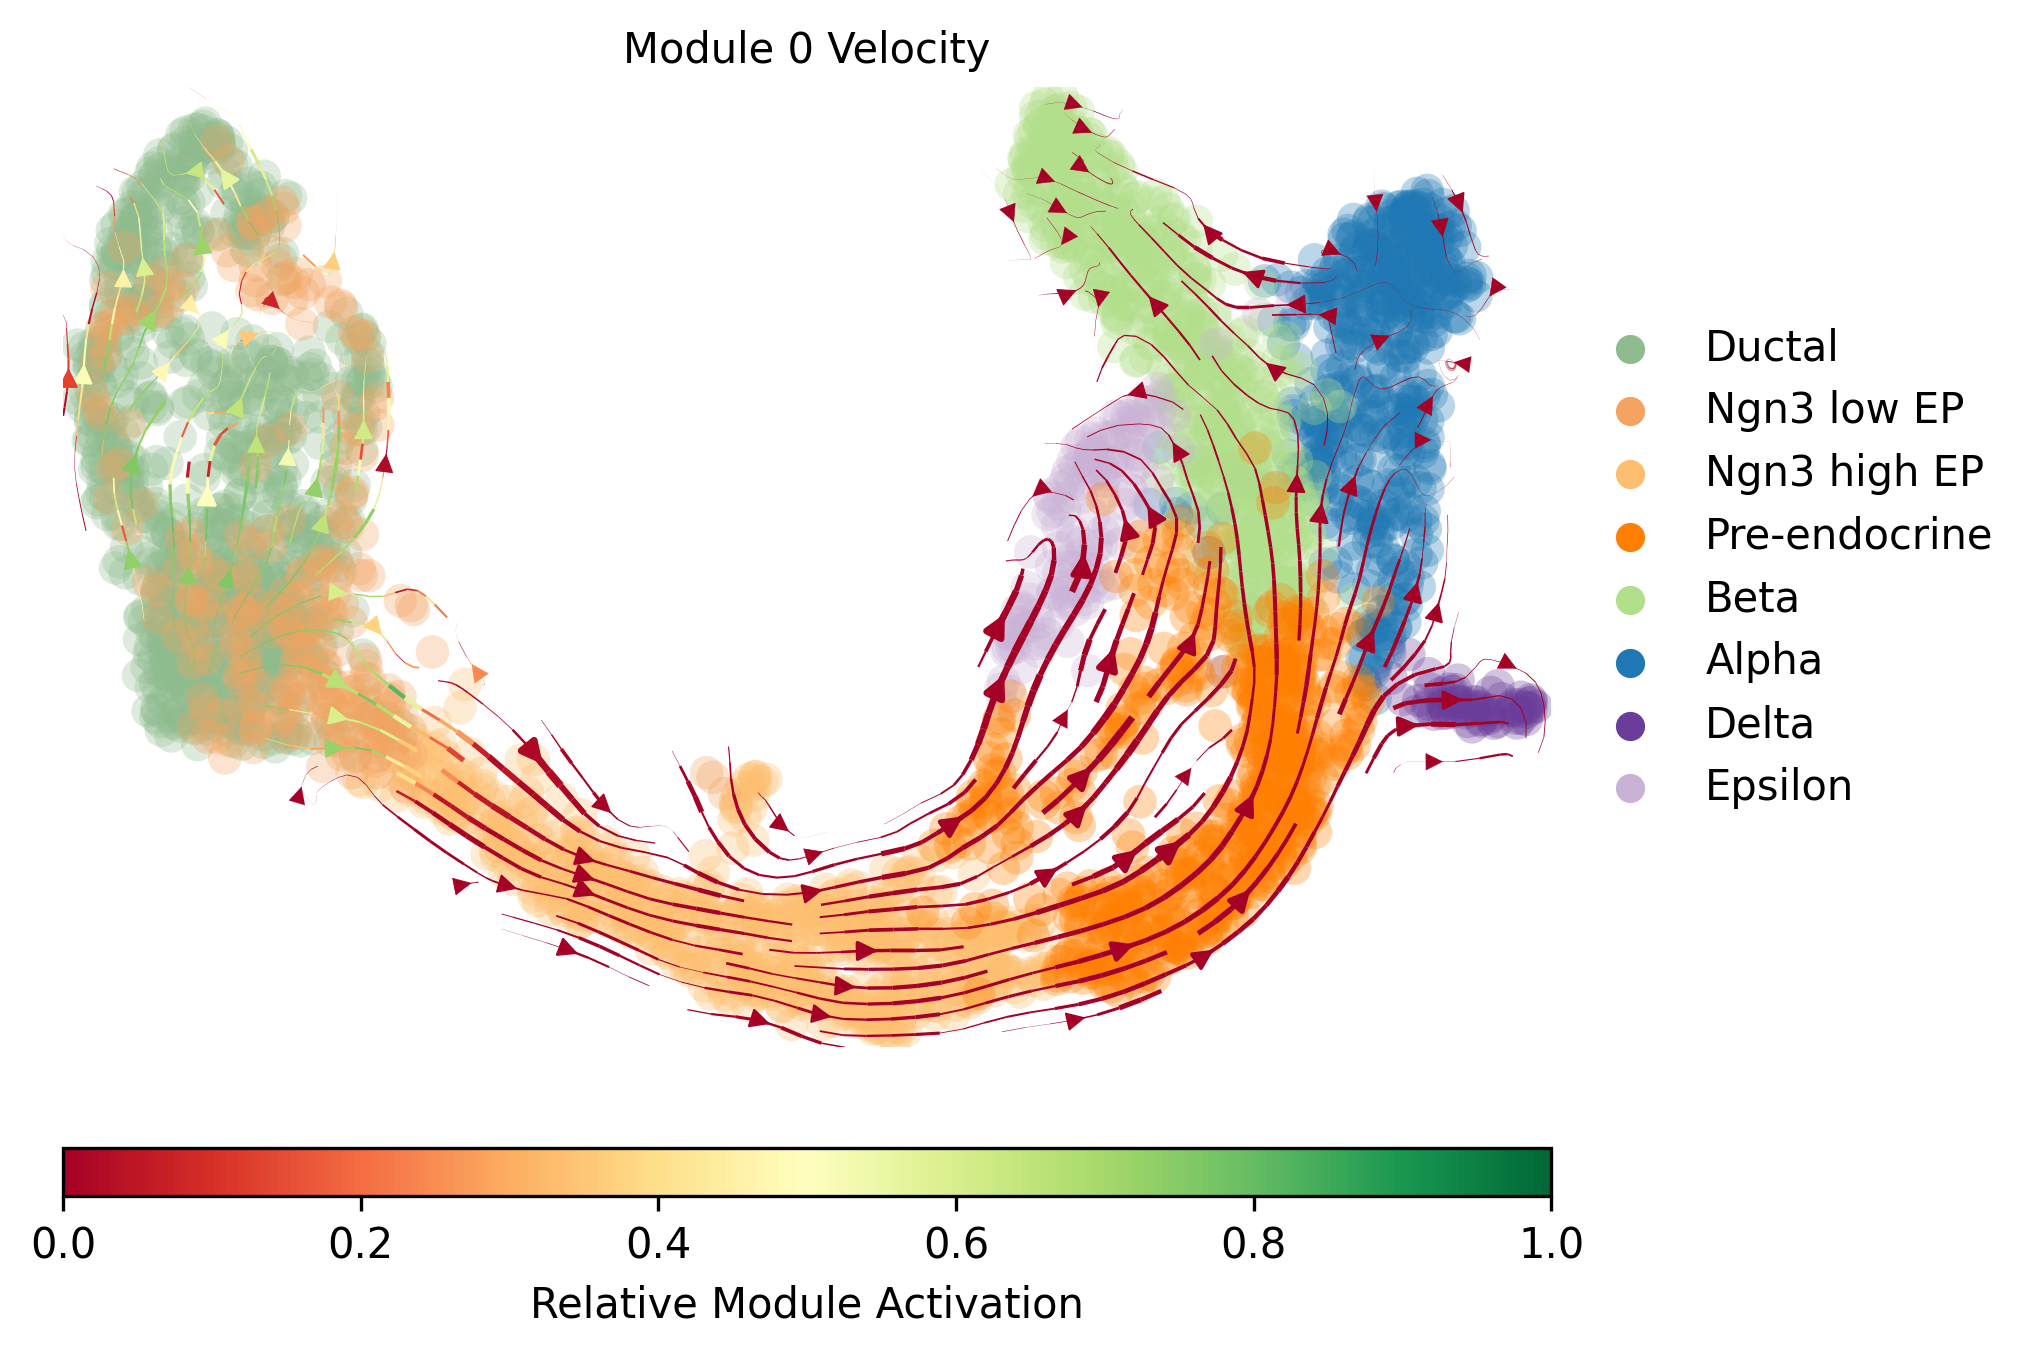

In [18]:
chosen_module = 0
plotting_kwargs={"color": 'clusters', 'legend_fontsize': 10, 'legend_loc': 'right_margin', 'dpi': 300, 'cmap': 'RdYlGn'}
mod.visualize_module_trajectories(adata, chosen_module, plotting_kwargs=plotting_kwargs)
plt.savefig(results_path + data_name + 'module_0_velocities.png', bbox_inches='tight')

In [19]:
adata

AnnData object with n_obs × n_vars = 3696 × 3000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', '_indices', '_scvi_batch', 'Time (hours)', 'Time Uncertainty (QCD)', 'Module 0 Activation', 'Module 0 State', 'Module 1 Activation', 'Module 1 State', 'Module 2 Activation', 'Module 2 State', 'Module 3 Activation', 'Module 3 State', 'Module 4 Activation', 'Module 4 State', 'Module 5 Activation', 'Module 5 State', 'Module 6 Activation', 'Module 6 State', 'Module 7 Activation', 'Module 7 State', 'Module 8 Activation', 'Module 8 State', 'Module 9 Activation', 'Module 9 State', 'Module 10 Activation', 'Module 10 State', 'Module 11 Activation', 'Module 11 State', 'Module 12 Activation', 'Module 12 State', 'Module 13 Activation', 'Module 13 State', 'Module 14 Activation', 'Module 14 State', 'velocity_self_transition'
    var: 'highly_variable_genes', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

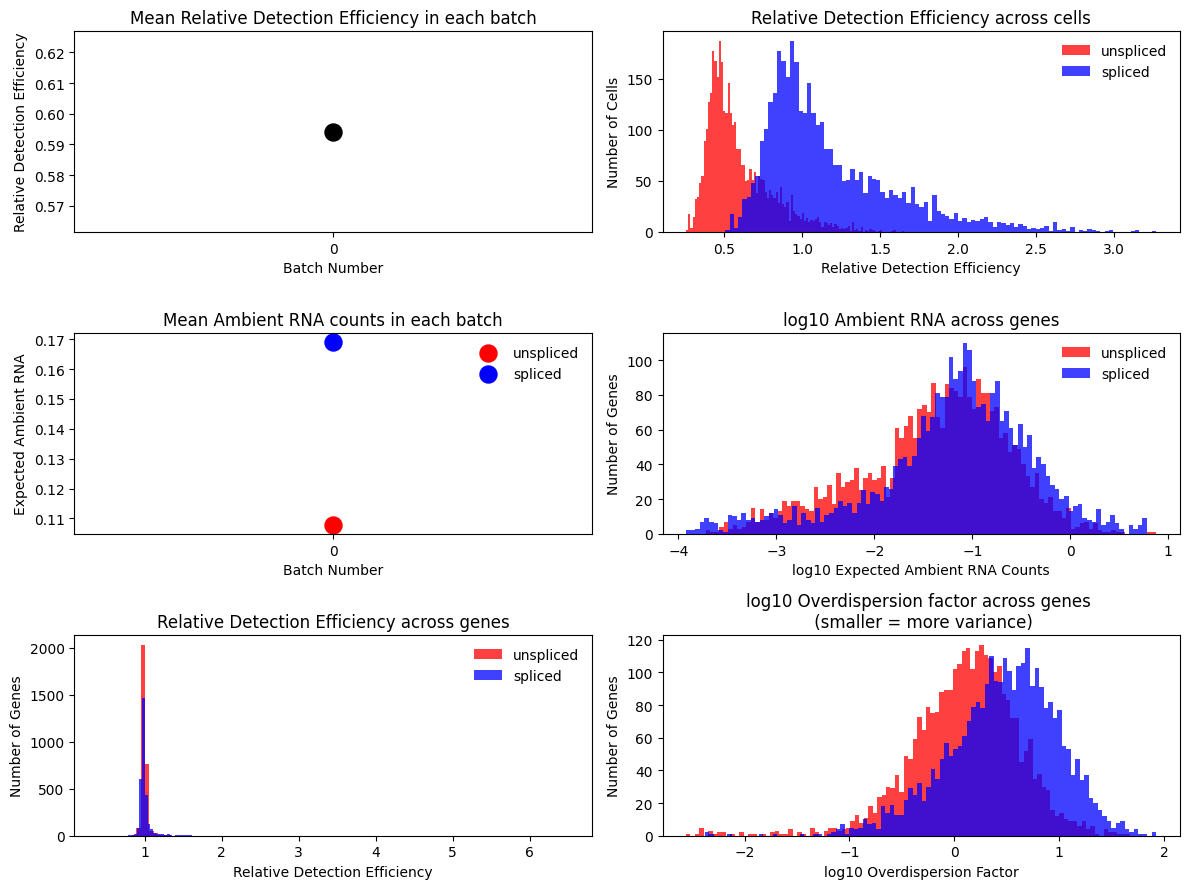

In [20]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [21]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.042552438
gamma_g mean: 0.9567946
beta_g mean: 1.3084458
lam_mi, all modules: 
 
 [[[17.96 15.23]]

 [[ 4.85  4.76]]

 [[ 0.38  0.51]]

 [[ 0.33  0.55]]

 [[ 0.48  0.77]]

 [[ 1.01  0.94]]

 [[ 0.66  0.74]]

 [[ 0.75  0.88]]

 [[ 0.76  0.79]]

 [[ 0.84  0.84]]

 [[ 1.24  1.2 ]]

 [[ 1.31  1.26]]

 [[ 0.83  0.81]]

 [[ 0.09  0.1 ]]

 [[ 0.87  0.88]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [22]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')

In [23]:
tab

Module Number                                       Genes Ranked  \
0               0  Ldhb, Shroom3, S100b, Hnf1b, Shank2, Capg, Smt...   
1               1  Krt23, Igf1, Fmo1, Nfkbiz, Ankrd1, Gc, Nrp1, S...   
2               2  Serpina6, Ass1, Tmem171, Notch1, Dll1, Aldh1b1...   
3               3  Dll1, Nptx2, Calml4, Igdcc4, Bcl2, Dach2, Qsox...   
4               4  Btbd11, Notum, Scube1, Tspear, Sh3bgrl3, Ppp1r...   
5               5  Adamts18, Afap1, Scube1, Epb42, Srrm4, Fam210b...   
6               6  Sulf1, Clstn2, Bach2, Prdm16, Rnf220, Ebf1, Dg...   
7               7  Ypel2, Smpdl3a, Dusp16, Diras2, Zfp804a, Fev, ...   
8               8  Palld, Cep290, Asb3, Pcdh7, Hdgfrp3, Tsc22d1, ...   
9               9  Nlgn1, Ndst4, Irx2, Gk, Gria2, AW554918, Peg10...   
10             10  Ins1, Syt9, Hpgds, Nell1, Skap1, Tnr, Pou6f2, ...   
11             11  Ins2, Npy, Nnat, Sntg1, Mapt, Ptprz1, Sdf2l1, ...   
12             12  Ntm, P2ry1, Itpkb, Arhgap36, Cntfr, Sytl4, Npy...   
13             13  Ccl4, Stmn2, Ccl9, Zeb2, Ankrd1, Zfp804a, Cdh1...   
14             14  Ccl4, Stmn2, Ccl9, Zeb2, Ankrd1, Zfp804a, Cdh1...   

                                           TFs Ranked  \
0   Hnf1b, Klf5, Sox5, Rest, Sox9, Zfp36l1, Hes1, ...   
1   Nfkbiz, Nr4a1, Hmga2, Zfhx3, Dnmt1, Arid5b, Hn...   
2   Rest, Ehf, Eno1, Zfp36l1, Nr4a1, Elf5, Nfib, Z...   
3   Dach2, Nfix, Tcf20, Smarcd2, Neurog3, E2f1, Kl...   
4   Zfpm1, E2f1, Smarcd2, Rbpj, Nfic, Zfp423, Ncor...   
5   Pbx1, Zfp423, Foxo3, Rbpj, Neurog3, Setbp1, Fo...   
6   Bach2, Prdm16, Ebf1, Runx1t1, Lcorl, Zfp7, Kcn...   
7   Zfp804a, Prdm16, Ebf1, Vdr, Zfp7, Etv5, Zfp174...   
8   Tsc22d1, Fos, Zfp1, Ets2, Tshz3, Peg3, Zfp804a...   
9   Irx2, Smarca1, Etv1, Foxn3, Arx, Sp4, Cux2, Nc...   
10  Tcf4, Srebf2, Myt1l, Meis2, Hivep3, Zfp26, Ror...   
11  Rora, Pcbp3, Smarca2, Tshz1, Srebf2, Npas3, At...   
12  Glis3, Smarca2, Pcbp3, Rora, Pdx1, Satb1, Ddit...   
13  Zeb2, Zfp804a, Arntl, Zfp799, Relb, Zfp867, Da...   
14  Zeb2, Zfp804a, Arntl, Zfp799, Relb, Zfp867, Da...   

                                         Terms Ranked  
0   chromatin assembly (GO:0031497), cellular comp...  
1   mitotic spindle organization (GO:0007052), reg...  
2   mitotic spindle organization (GO:0007052), mic...  
3                                                      
4                                                      
5                                                      
6                                                      
7                                                      
8                                                      
9                                                      
10                                                     
11  IRE1-mediated unfolded protein response (GO:00...  
12  protein N-linked glycosylation via asparagine ...  
13  calcium-dependent cell-cell adhesion via plasm...  
14  calcium-dependent cell-cell adhesion via plasm...

In [24]:
all_results[0]

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   
8  GO_Biological_Process_2021   
9  GO_Biological_Process_2021   

                                                Term   P-value  \
0                    chromatin assembly (GO:0031497)  0.000004   
1           cellular component assembly (GO:0022607)  0.000015   
2  regulation of stem cell proliferation (GO:0072...  0.000017   
3  positive regulation of cell population prolife...  0.000027   
4  regulation of cell population proliferation (G...  0.000033   
5  regulation of mesenchymal cell proliferation (...  0.000036   
6  regulation of mesenchymal stem cell differenti...  0.000036   
7  positive regulation of mesenchymal cell prolif...  0.000036   
8                membrane raft assembly (GO:0001765)  0.000036   
9  positive regulation of intracellular signal tr...  0.000063   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.005011            0                     0   38.105263   
1          0.005011            0                     0    6.601852   
2          0.005011            0                     0   60.375000   
3          0.005011            0                     0    4.999410   
4          0.005011            0                     0    4.018322   
5          0.005011            0                     0         inf   
6          0.005011            0                     0         inf   
7          0.005011            0                     0         inf   
8          0.005011            0                     0         inf   
9          0.007951            0                     0    4.924672   

   Combined Score                                              Genes  
0      471.554630                     CHAF1B;CHAF1A;HMGB2;HMGA2;SOX9  
1       73.395952  SLC9A3R1;CHAF1B;CHAF1A;PDGFA;CAPG;HES1;SOX9;GA...  
2      664.573271                           GJA1;HMGB2;HMGA2;ZFP36L1  
3       52.549109  BST2;TCF7L2;GJA1;PDGFA;HMGA2;EMP2;HES1;SOX9;S1...  
4       41.478425  TCF7L2;OSGIN1;HMGB2;PDGFA;EMP2;S100B;ZFP36L1;S...  
5             inf                                   PDGFA;SOX9;FGFR2  
6             inf                                     REST;SOX9;SOX5  
7             inf                                   PDGFA;SOX9;FGFR2  
8             inf                                 ANXA2;EMP2;S100A10  
9       47.601978  BST2;SLC9A3R1;TCF7L2;GJA1;PLK2;WWC1;PDGFA;SOX9...

To plot the expression and RNA velocity of individual module marker genes:

<AxesSubplot:title={'center':'Npy velocity'}, xlabel='UMAP1', ylabel='UMAP2'>

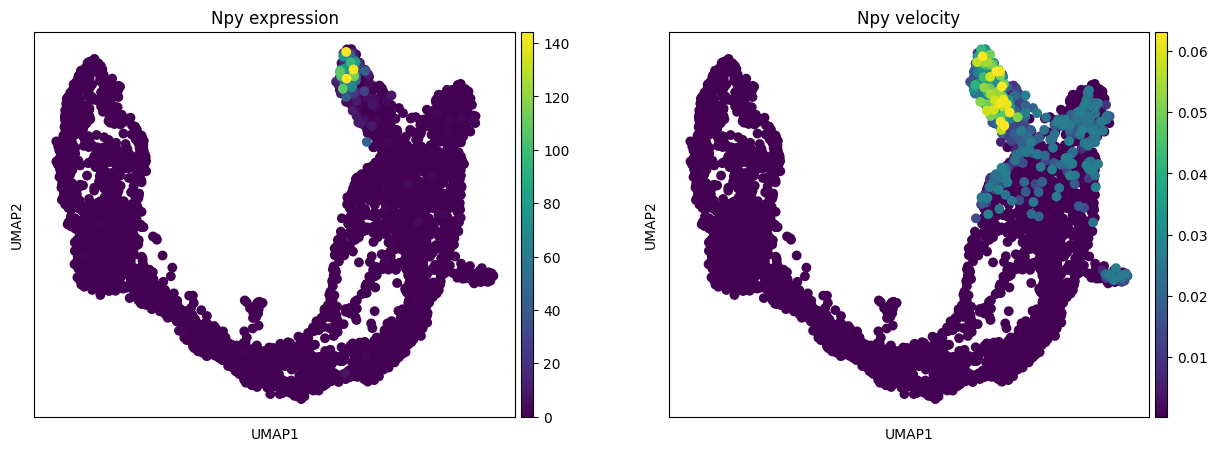

In [25]:
gene = 'Npy'
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sc.pl.umap(adata, color = [gene], s = 200, legend_loc='on data', show = False,
           title = gene + ' expression', ax = ax[0])
sc.pl.umap(adata, color = [gene], s = 200, legend_loc='on data', show = False,
           layer = 'velocity', title = gene + ' velocity', ax = ax[1])